# Task 1: Cubic-Quintic-Duffing Oscillator
Sam Greydanus

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-CQD'
sys.path.append(EXPERIMENT_DIR)

from data_cqd import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 5000,
         'field_type': 'solenoidal',
         'print_every': 50,
         'name': 'cqd',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

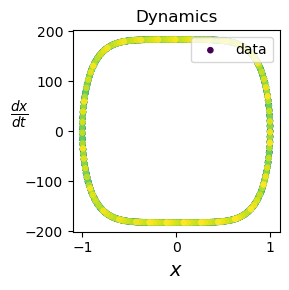

In [3]:
args = ObjectView(get_args())
x, y, dx, dy, t = get_trajectory(radius=1, timescale=1000, y0=np.array([0.5,0]))

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=100)
plt.scatter(x,y,c=t,s=14, label='data')
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [4]:
x.shape

(1000,)

## Construct models

In [5]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/{}.tar".format(args.save_dir, 'cqd-hnn')
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [6]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [7]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [8]:
hnn_model = get_model(args, baseline=False)

# integrate along those fields starting from point (1,0)
t_span = [0,1]
y0 = np.asarray([0.5, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}

hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

In [9]:
hnn_ivp['y'].shape

(2, 1000)

In [10]:
x.shape

(1000,)

## Plot results

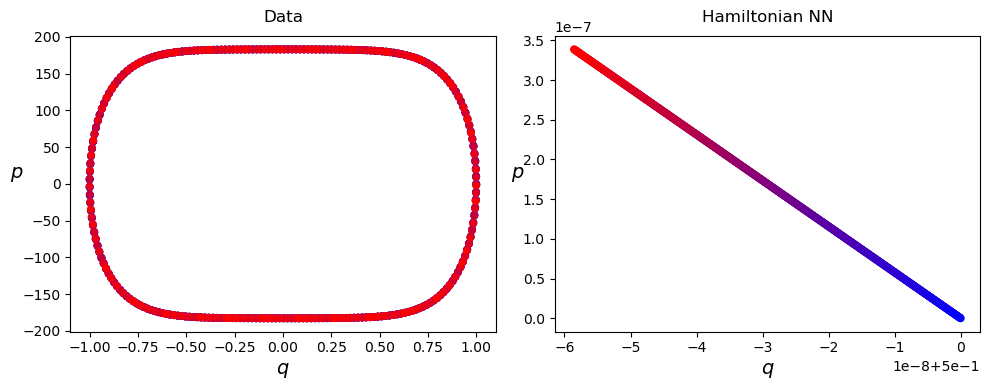

In [11]:
###### PLOT ######
fig = plt.figure(figsize=(10,4), facecolor='white', dpi=100)

# plot dynamics
fig.add_subplot(1, 2, 1, frameon=True)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x, y, s=22, label='data', c=point_colors)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot HNN
fig.add_subplot(1, 2, 2, frameon=True)
xhnn, yhnn = np.split(hnn_ivp['y'], 2)
plt.scatter(xhnn, yhnn, s=22, label='HNN', c=point_colors)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout() 
plt.show()


## Quantitative analysis

* Compare the energies, Hamiltonian

In [12]:
def true_Hamiltonian(state, m=1, a=1000, b=5000, c=90000):
    q, q_dot = state
    T = 0.5 * m * q_dot**2
    V = 0.5*a*q**2 + 0.25*b*q**4 + (1/6)*c*q**6
    return T + V

samples = 25
H_true_ensemble = []
H_hnn_ensemble = []
for i in range(samples):
    print('Sample-{}'.format(i))
    
    y_init = np.random.uniform(0.1,0.5)
    t_span = [0,1]
    y0 = np.asarray([y_init, 0])
    
    x_, y_, _, _, _ = get_trajectory(t_span = t_span, radius=1, timescale=1000, y0=y0)
    
    kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
    hnn_ivp_ = integrate_model(hnn_model, [0,1.0], y0, **kwargs)
    
    H_true = true_Hamiltonian([x_, y_])
    H_hnn = hamiltonian_fn(hnn_ivp_['y'])[0]
    
    H_true_ensemble.append( H_true )
    H_hnn_ensemble.append( H_hnn )

H_true_ensemble = np.array( H_true_ensemble ) 
H_hnn_ensemble = np.array( H_hnn_ensemble )


Sample-0
Sample-1
Sample-2
Sample-3
Sample-4
Sample-5
Sample-6
Sample-7
Sample-8
Sample-9
Sample-10
Sample-11
Sample-12
Sample-13
Sample-14
Sample-15
Sample-16
Sample-17
Sample-18
Sample-19
Sample-20
Sample-21
Sample-22
Sample-23
Sample-24


In [13]:
error_HNN = np.abs(H_hnn_ensemble - H_true_ensemble)/ np.abs(H_true_ensemble)

mean_HNN = np.mean(error_HNN, axis = 0)
std_HNN = np.std(error_HNN, axis = 0)

print(error_HNN.shape)


(25, 1000)


In [14]:
error_HNN

array([[0.98804037, 0.98804037, 0.98804037, ..., 0.98804038, 0.98804038,
        0.98804038],
       [0.99689167, 0.99689167, 0.99689167, ..., 0.99689167, 0.99689167,
        0.99689167],
       [0.99940976, 0.99940976, 0.99940976, ..., 0.99940976, 0.99940976,
        0.99940976],
       ...,
       [0.99090074, 0.99090074, 0.99090074, ..., 0.99090075, 0.99090075,
        0.99090075],
       [0.99839352, 0.99839352, 0.99839352, ..., 0.99839352, 0.99839352,
        0.99839352],
       [0.99828916, 0.99828916, 0.99828916, ..., 0.99828916, 0.99828916,
        0.99828916]])

In [15]:
print('L2 error: HNN--', 100*np.mean(error_HNN))

L2 error: HNN-- 99.27640452224594


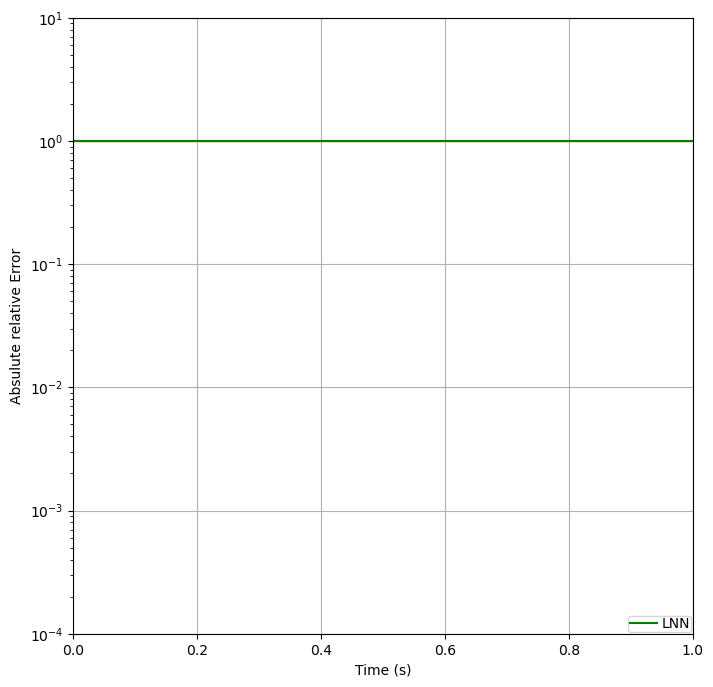

In [19]:
fig4 = plt.figure(figsize=(8,8), dpi=100)
plt.plot( np.linspace(0, 1, 1000), mean_HNN, 'g' , label='LNN' )
plt.fill_between(np.linspace(0, 1, 1000), mean_HNN-(1/np.sqrt(samples))*std_HNN, 
                 mean_HNN+(1/np.sqrt(samples))*std_HNN,
                 color='orange', alpha=0.25)

plt.ylabel('Absulute relative Error')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.ylim([1e-4,10])
plt.legend(loc=4, labelspacing=0.1, borderaxespad=0.1, handletextpad=0.3, borderpad=0.1)
plt.margins(0)
plt.grid(True)

# fig4.savefig('Error_nonlin_total_energy.pdf', format='pdf', dpi=600, bbox_inches='tight')


In [17]:
from scipy import io as sio

In [18]:
sio.savemat('Results_cqd_HNN.mat', mdict={'H_true_ensemble':H_true_ensemble,
                                                'H_hnn_ensemble':H_hnn_ensemble,
                                                'error_HNN':error_HNN, })
